## Import the libraries

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mutual_info_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## Read the data

In [2]:
df = pd.read_csv('customer_churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Visualize column names

In [4]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [5]:
#Check unique values of each columns
for column in df.columns:
    print('Column: {} - Unique Values: {}'.format(column,df[column].unique()))

Column: customerID - Unique Values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Column: gender - Unique Values: ['Female' 'Male']
Column: SeniorCitizen - Unique Values: [0 1]
Column: Partner - Unique Values: ['Yes' 'No']
Column: Dependents - Unique Values: ['No' 'Yes']
Column: tenure - Unique Values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Column: PhoneService - Unique Values: ['No' 'Yes']
Column: MultipleLines - Unique Values: ['No phone service' 'No' 'Yes']
Column: InternetService - Unique Values: ['DSL' 'Fiber optic' 'No']
Column: OnlineSecurity - Unique Values: ['No' 'Yes' 'No internet service']
Column: OnlineBackup - Unique Values: ['Yes' 'No' 'No internet service']
Column: DeviceProtection - Unique Values: ['No' 'Yes' 'No internet service']
Column: TechSuppor

## Comment about the variables

The dataset contains 19 variables. They can be classified into 3 groups:

(1) Demographic Information

gender, SeniorCitizen, Partner, Dependents.

(2) Customer Account Information

tenure, Contract, PaperlessBilling, PaymentMethod, MontlyCharges, TotalCharges.

(3) Services Information

PhoneService, MultipleLines, InternetServices, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies.

## Exploratory Data Analysis and Data Cleaning

In [6]:
#Summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
#Transform the TotalCharges into a numeric data type
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

In [8]:
df['TotalCharges'].isnull().sum()

11

In [9]:
#Drop the null values
df.dropna(inplace=True)

In [10]:
#Customer_id column is useless to explain the customer churn so, drop the customer_id column
df.drop(columns ='customerID', inplace= True)

## Payment Method Denomination

In [11]:
#Unique elements of the payment method
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [12]:
#It can be problematic "(automatic)" when using labels.
#Remove (automatic) from payment method names
df['PaymentMethod']=df['PaymentMethod'].str.replace('(automatic)', '', regex = False)

# Data Visualization

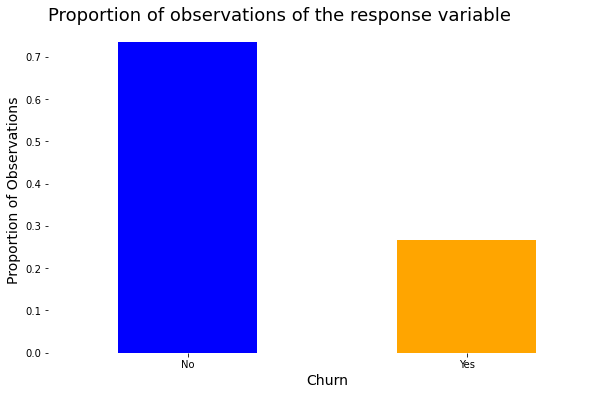

In [13]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

#proprotion of observation of each class
prop_obs = df['Churn'].value_counts(normalize=True)

prop_obs.plot(kind = 'bar',
             ax = ax,
              color = ['blue', 'orange']
             )
ax.tick_params(rotation = 'auto')

#Set title and label
plt.title ('Proportion of observations of the response variable',
             fontsize=18, loc='left')
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Proportion of Observations', fontsize=14)

#eliminate the frame from the plot
spine_names = ('top', 'right', 'bottom','left')
for spine_name in spine_names:
    ax.spines[spine_name].set_visible(False)

In [36]:
def percentage_stacked_plot(columns_to_plot, super_title):
    
    '''Parameters:
    
            columns_to_plot: (list of string): Names of the variables to plot
            super_title (string): Super title of the visualization
    '''
    num_of_columns = 2
    num_of_rows = math.ceil(len(columns_to_plot)/2)
    
    #Create figure
    fig = plt.figure(figsize=(12,7*num_of_rows))
    fig.suptitle(super_title, fontsize=22, y = .95)
    
    #loop the each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):
        
        #create a subplot
        ax = fig.add_subplot(num_of_rows, num_of_columns,index)
        
        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(df[column], df['Churn']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0, color=['blue','orange'])

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        # set title and labels
        ax.set_title('Proportion of observations by ' + column,
                     fontsize=16, loc='left')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

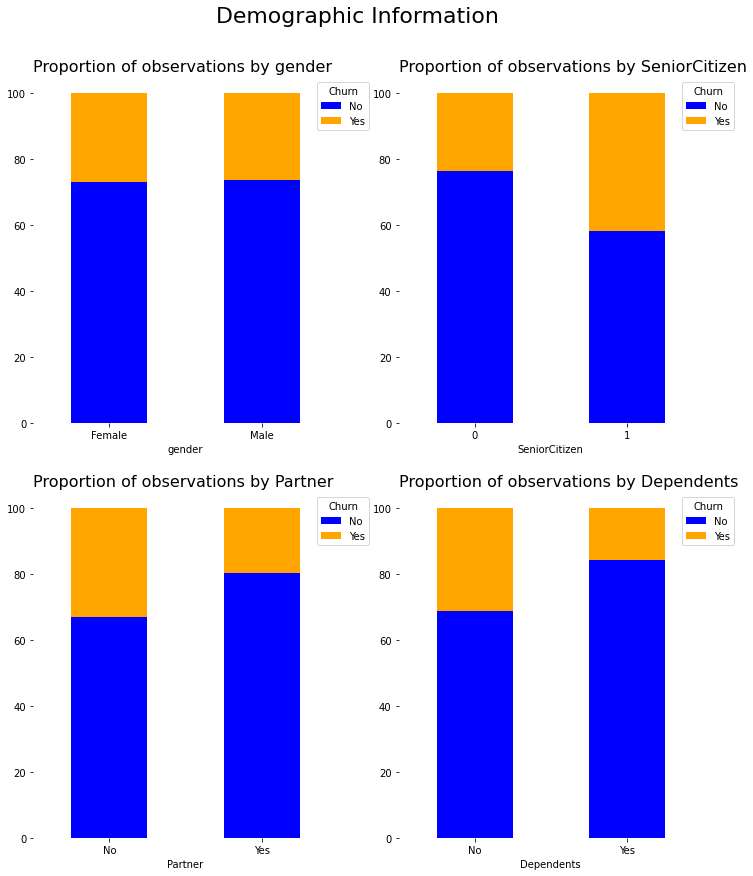

In [37]:
# demographic column names
demographic_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

# stacked plot of demographic columns
percentage_stacked_plot(demographic_columns, 'Demographic Information')

## Interpretation of the Demographic Information

We can reach the following conclusions by analyzing demographic attributes:

    The churn rate of senior citizens is almost double that of young citizens.
    
    We do not expect gender to have significant predictive power. A similar percentage of churn is shown both when a 
    customer is a man or a woman.
    
    Customers with a partner churn less than customers with no partner. 

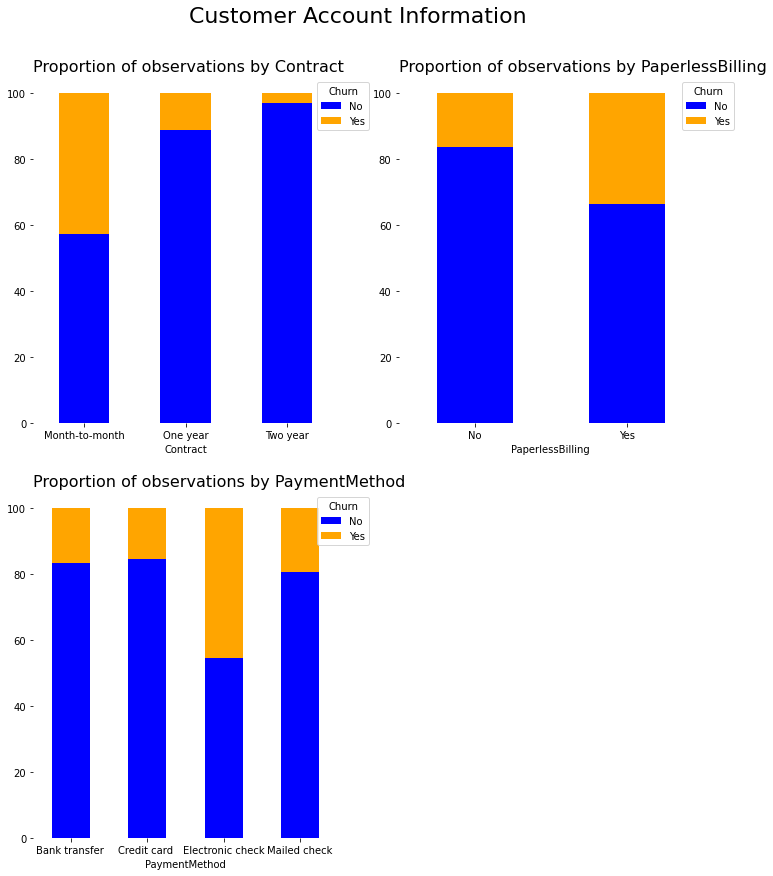

In [38]:
#Customer Account column names

cust_account_columns = ['Contract', 'PaperlessBilling', 'PaymentMethod']

# stacked plot of customer account columns
percentage_stacked_plot(cust_account_columns, 'Customer Account Information')


In [33]:
def hist_plots(columns_to_plot, super_title):
    '''
     Prints a histogram for each independent variable of the list columns_to_plot.
            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization
            Returns:
                    None
    '''
    #set the number of rows and number of columns
    
    num_of_columns = 2
    num_of_rows = math.ceil(len(columns_to_plot)/2)
    
    #create a figure
    
    fig= plt.figure(figsize=(12 , 5*num_of_rows))
    fig.suptitle(super_title, fontsize=22,  y=.95)
    # loop to each demographic column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(num_of_rows, num_of_columns, index)

        # histograms for each class (normalized histogram)
        df[df['Churn']=='No'][column].plot(kind='hist', ax=ax, density=True, 
                                                       alpha=0.5, color='orange', label='No')
        df[df['Churn']=='Yes'][column].plot(kind='hist', ax=ax, density=True,
                                                        alpha=0.5, color='blue', label='Yes')
        
        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        # set title and labels
        ax.set_title('Distribution of ' + column + ' by churn',
                     fontsize=16, loc='left')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)
    

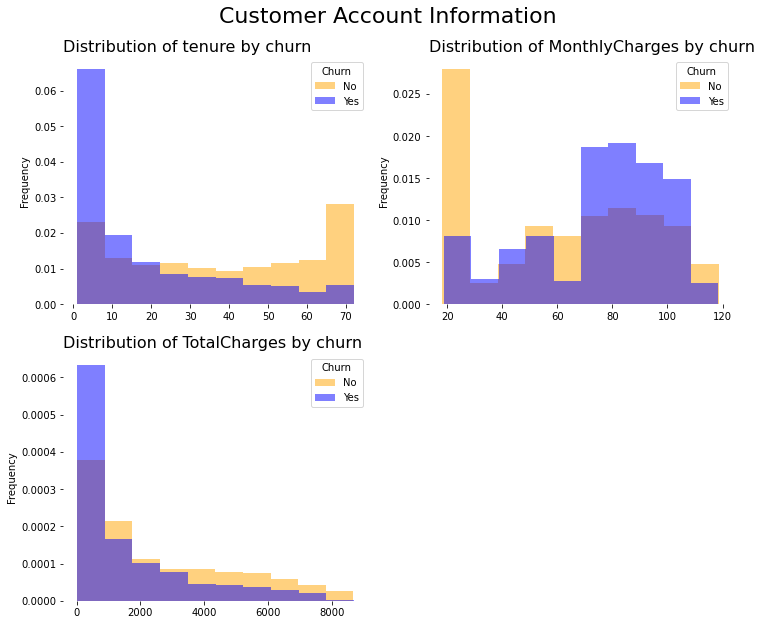

In [39]:
# customer account column names
account_columns_numeric = ['tenure', 'MonthlyCharges', 'TotalCharges']
# histogram of costumer account columns 
hist_plots(account_columns_numeric, 'Customer Account Information')

## Evaluation of the Customer Account 

We can reach the following conclusions by analyzing customer account attributes:

    Customers with month-to-month contracts have higher churn rates compared to clients with yearly contracts.
    
    Customers who opted for an electronic check as paying method are more likely to leave the company.
    
    Customers subscribed to paperless billing churn more than those who are not subscribed.

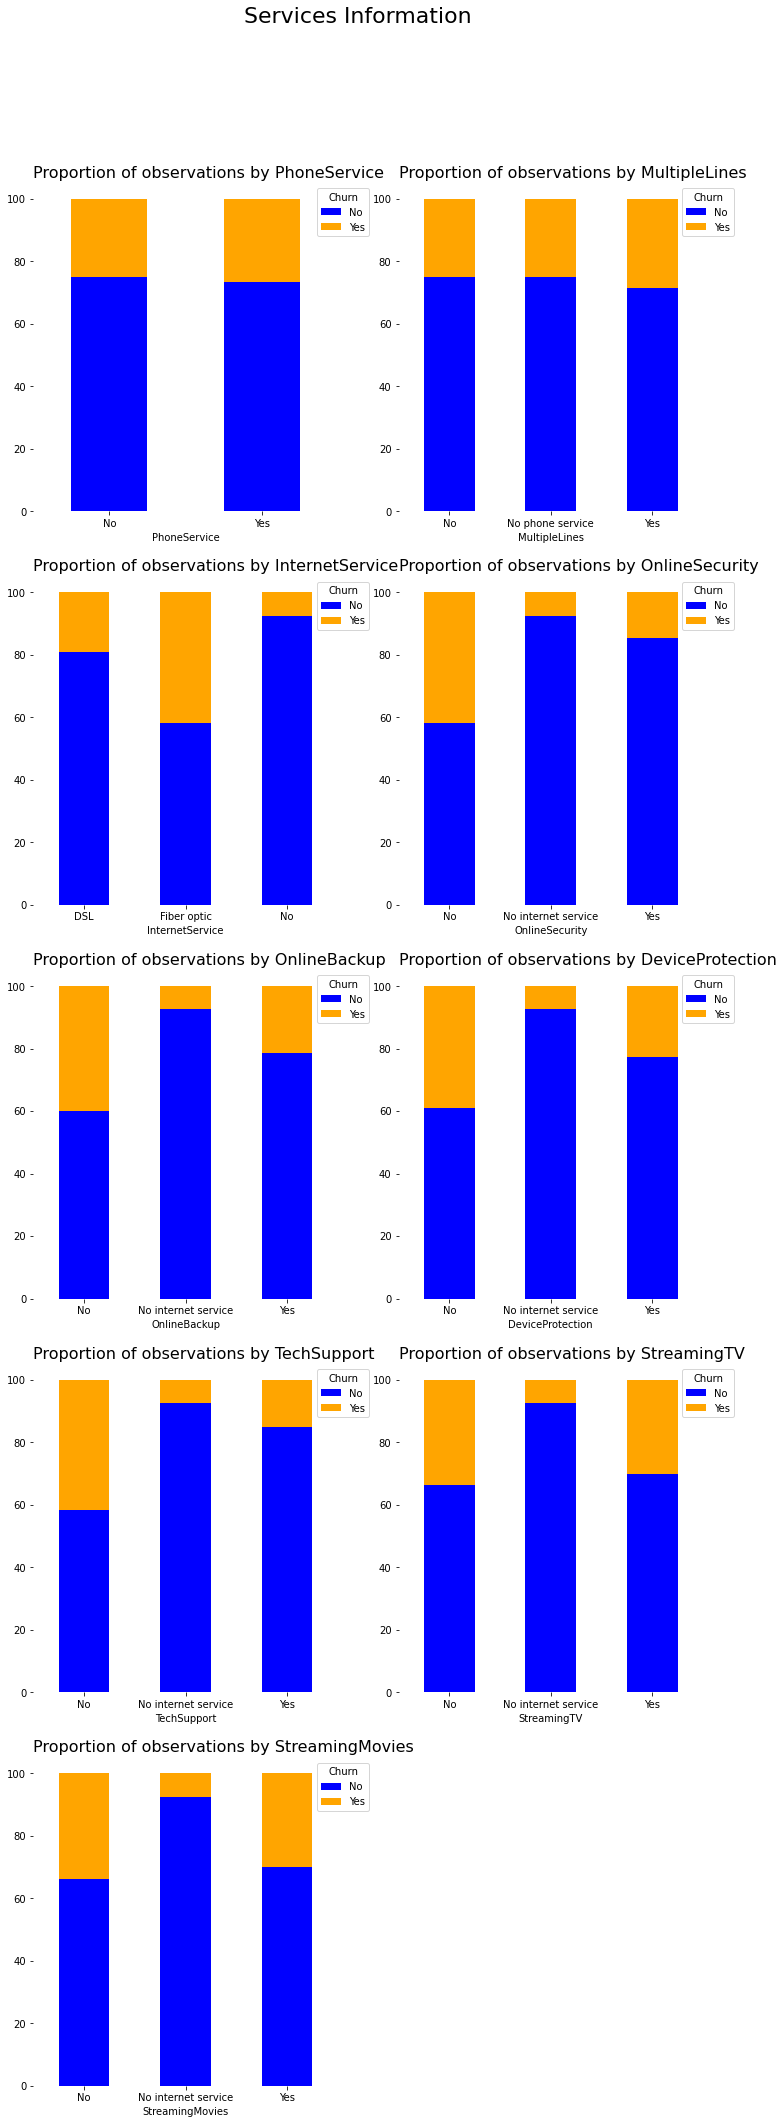

In [40]:
# services column names
services_columns = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# stacked plot of services columns
percentage_stacked_plot(services_columns, 'Services Information')

## Evaluation of the Service Information

We can reach the following conclusions by evaluating services attributes:

    We do not expect phone attributes (PhoneService and MultipleLines) to have significant predictive power. 
    
    The percentage of churn for all classes in both independent variables is nearly the same.
    
    Clients with online security churn less than those without it.
    
    Customers with no tech support tend to churn more often than those with tech support.

# Feature Importance

In [54]:
# function that computes the mutual infomation score between a categorical serie and the column Churn
def compute_mutual_information(categorical_serie):
    return mutual_info_score(categorical_serie, df['Churn'])

# select categorial variables excluding the response variable 
categorical_variables = df.select_dtypes(include=object).drop('Churn', axis=1)

# compute the mutual information score between each categorical variable and the target
feature_importance = categorical_variables.apply(compute_mutual_information).sort_values()

# visualize feature importance
print(feature_importance)

gender              0.000037
PhoneService        0.000069
MultipleLines       0.000798
Partner             0.011383
Dependents          0.014270
PaperlessBilling    0.019119
StreamingTV         0.031803
StreamingMovies     0.031918
DeviceProtection    0.043784
PaymentMethod       0.044423
OnlineBackup        0.046659
InternetService     0.055394
TechSupport         0.062873
OnlineSecurity      0.064528
Contract            0.098182
dtype: float64


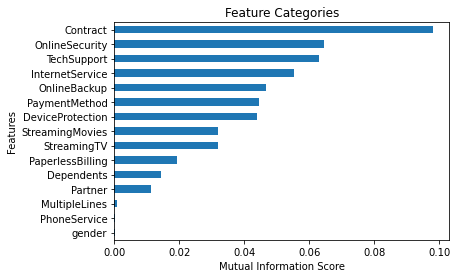

In [55]:
feature_importance.plot(kind='barh')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.title('Feature Categories')
plt.show()

# Feature Engineering

## Label Encoding

In [57]:
df_transformed = df.copy()

# label encoding (binary variables)
label_encoding_columns = ['gender', 'Partner', 'Dependents', 'PaperlessBilling', 'PhoneService', 'Churn']

# encode categorical binary features using label encoding
for column in label_encoding_columns:
    if column == 'gender':
        df_transformed[column] = df_transformed[column].map({'Female': 1, 'Male': 0})
    else: 
        df_transformed[column] = df_transformed[column].map({'Yes': 1, 'No': 0}) 

In [58]:
df_transformed.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,0,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,0,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,0,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer,42.30,1840.75,0
4,1,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


## One-Hot Encoding

In [70]:
# one-hot encoding (categorical variables with more than two levels)
one_hot_encoding_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                            'TechSupport', 'StreamingTV',  'StreamingMovies', 'Contract', 'PaymentMethod']

# encode categorical variables with more than two levels using one-hot encoding
df_transformed = pd.get_dummies(df_transformed, columns = one_hot_encoding_columns)

## Min-Max Normalization

In [72]:
# min-max normalization (numeric variables)
min_max_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# scale numerical variables using min max scaler
for column in min_max_columns:
        # minimum value of the column
        min_column = df_transformed[column].min()
        # maximum value of the column
        max_column = df_transformed[column].max()
        # min max scaler
        df_transformed[column] = (df_transformed[column] - min_column) / (max_column - min_column)   


# Splitting the data in train and test

In [86]:
#Features
X = df_transformed.drop(columns = 'Churn')

#Target value
y = df_transformed['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=40, shuffle=True)

# Assesing multiple algorithms

In [94]:
def create_models(seed=2):
    '''
    Create a list of machine learning models.
            Parameters:
                    seed (integer): random seed of the models
            Returns:
                    models (list): list containing the models
    '''

    models = []
    models.append(('dummy_classifier', DummyClassifier(random_state=seed, strategy='most_frequent')))
    models.append(('k_nearest_neighbors', KNeighborsClassifier()))
    models.append(('logistic_regression', LogisticRegression(random_state=seed)))
    models.append(('support_vector_machines', SVC(random_state=seed)))
    models.append(('random_forest', RandomForestClassifier(random_state=seed)))
    models.append(('gradient_boosting', GradientBoostingClassifier(random_state=seed)))
    
    return models

# create a list with all the algorithms we are going to assess
models = create_models()

In [95]:
# test the accuracy of each model using default hyperparameters
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    # fit the model with the training data
    model.fit(X_train, y_train).predict(X_test)
    # make predictions with the testing data
    predictions = model.predict(X_test)
    # calculate accuracy 
    accuracy = accuracy_score(y_test, predictions)
    # append the model name and the accuracy to the lists
    results.append(accuracy)
    names.append(name)
    # print classifier accuracy
    print('Classifier: {}, Accuracy: {})'.format(name, accuracy))

Classifier: dummy_classifier, Accuracy: 0.745164960182025)
Classifier: k_nearest_neighbors, Accuracy: 0.7531285551763367)
Classifier: logistic_regression, Accuracy: 0.7923777019340159)


C:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classifier: support_vector_machines, Accuracy: 0.7878270762229806)
Classifier: random_forest, Accuracy: 0.7713310580204779)
Classifier: gradient_boosting, Accuracy: 0.7963594994311718)


## Gradient Boosting 
We choose Gradient Boosting because it gave us to best score

In [97]:
# define the parameter grid
grid_parameters = {'n_estimators': [80, 90, 100, 110, 115, 120],
                   'max_depth': [3, 4, 5, 6],
                   'max_features': [None, 'auto', 'sqrt', 'log2'], 
                   'min_samples_split': [2, 3, 4, 5]}


# define the RandomizedSearchCV class for trying different parameter combinations
random_search = RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                                   param_distributions=grid_parameters,
                                   cv=5,
                                   n_iter=150,
                                   n_jobs=-1)

# fitting the model for random search 
random_search.fit(X_train, y_train)

# print best parameter after tuning
print(random_search.best_params_)

{'n_estimators': 100, 'min_samples_split': 4, 'max_features': 'log2', 'max_depth': 3}


## Performance the model

In [99]:
# make the predictions
random_search_predictions = random_search.predict(X_test)

# construct the confusion matrix
confusion_matrix = confusion_matrix(y_test, random_search_predictions)

# visualize the confusion matrix
confusion_matrix

array([[1148,  162],
       [ 194,  254]], dtype=int64)

In [101]:
# print classification report 
print(classification_report(y_test, random_search_predictions))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1310
           1       0.61      0.57      0.59       448

    accuracy                           0.80      1758
   macro avg       0.73      0.72      0.73      1758
weighted avg       0.79      0.80      0.79      1758



In [102]:
# print the accuracy of the model
accuracy_score(y_test, random_search_predictions)

0.7974971558589306

## Appendix: 

I followed 